### Setting Up Environment

In [222]:
import sys
print(sys.executable)

/ifshome/psenthilkumar/.conda/envs/synthbrain/bin/python


In [ ]:
!pip install -q "monai-weekly[tqdm, nibabel]" matplotlib

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm, nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [224]:
import sys
import os
print(sys.path)

['/ifshome/psenthilkumar/SYN/synth_2', '/ifshome/psenthilkumar/.conda/envs/synthbrain/lib/python38.zip', '/ifshome/psenthilkumar/.conda/envs/synthbrain/lib/python3.8', '/ifshome/psenthilkumar/.conda/envs/synthbrain/lib/python3.8/lib-dynload', '', '/ifshome/psenthilkumar/.conda/envs/synthbrain/lib/python3.8/site-packages', '/ifshome/psenthilkumar/.conda/envs/synthbrain/lib/python3.8/site-packages/IPython/extensions', '/ifshome/psenthilkumar/.conda/envs/synthbrain/lib/python3.8/site-packages/setuptools/_vendor', '/ifshome/psenthilkumar/.ipython', '/tmp/tmpw5enxrt1']


In [225]:
print(os.getcwd())

/ifshome/psenthilkumar/SYN/synth_2


In [226]:
os.chdir('/ifshome/psenthilkumar/SYN/synth_2')

# Verify the change
print(os.getcwd())

/ifshome/psenthilkumar/SYN/synth_2


In [227]:
from generative.networks.nets import VQVAE

# Check if it was imported without error
print(VQVAE)

<class 'generative.networks.nets.vqvae.VQVAE'>


### Importing Libraries

In [228]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism
from torch.nn import L1Loss
from tqdm import tqdm
from generative.networks.nets import VQVAE

print_config()

MONAI version: 1.3.0
Numpy version: 1.24.3
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /ifshome/<username>/.conda/envs/synthbrain/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.1
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.10.1
Pillow version: 10.4.0
Tensorboard version: 2.14.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.0+cu121
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.0.3
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details abo

In [229]:
import monai
dir(monai.networks.nets)

['AHNet',
 'AHnet',
 'Ahnet',
 'AttentionUnet',
 'AutoEncoder',
 'BasicUNet',
 'BasicUNetPlusPlus',
 'BasicUnet',
 'BasicUnetPlusPlus',
 'Basicunet',
 'BasicunetPlusPlus',
 'BertAttention',
 'BertMixedLayer',
 'BertOutput',
 'BertPreTrainedModel',
 'BlockArgs',
 'Classifier',
 'Critic',
 'DAF3D',
 'DenseNet',
 'DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'DenseNet264',
 'Densenet',
 'Densenet121',
 'Densenet169',
 'Densenet201',
 'Densenet264',
 'DiNTS',
 'Discriminator',
 'DynUNet',
 'DynUnet',
 'Dynunet',
 'EfficientNet',
 'EfficientNetBN',
 'EfficientNetBNFeatures',
 'EfficientNetEncoder',
 'FLEXUNET_BACKBONE',
 'FlexUNet',
 'FlexUNetEncoderRegister',
 'FlexibleUNet',
 'FullyConnectedNet',
 'Generator',
 'GlobalNet',
 'HighResBlock',
 'HighResNet',
 'HoVerNet',
 'HoVernet',
 'HoverNet',
 'Hovernet',
 'LocalNet',
 'MILModel',
 'MultiModal',
 'NetAdapter',
 'PatchMerging',
 'PatchMergingV2',
 'Pooler',
 'Quicknat',
 'RegUNet',
 'Regressor',
 'ResNet',
 'ResNetBlock',
 'ResNetBottle

In [230]:
import monai
print(monai.__file__)

/ifshome/psenthilkumar/.conda/envs/synthbrain/lib/python3.8/site-packages/monai/__init__.py


In [231]:
import os
import monai

path_to_monai = os.path.dirname(monai.__file__)
print(f"MONAI is installed at: {path_to_monai}")
print("Generative submodule exists:", os.path.isdir(os.path.join(path_to_monai, "generative")))

MONAI is installed at: /ifshome/psenthilkumar/.conda/envs/synthbrain/lib/python3.8/site-packages/monai
Generative submodule exists: False


In [232]:
import monai
print(monai.__version__)

1.3.0


In [233]:
from generative.networks.nets import VQVAE
print("VQVAE successfully imported!")

VQVAE successfully imported!


### Setting Up

In [234]:
# for reproducibility purposes set a seed
set_determinism(42)

### Temporary Folder creation

In [235]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpvvs2funv


In [236]:
import os

files = os.listdir(root_dir)
print("Files in the directory:", files)

Files in the directory: []


### Applying Transformations

In [237]:
train_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.Lambdad(keys="image", func=lambda x: x[:, :, :, 1]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.ScaleIntensityd(keys=["image"]),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=[176, 224, 155]),
        transforms.Resized(keys=["image"], spatial_size=(48,64,48)),
    ]
    
    ## try diff dim spatial_size=(32, 48, 32)
    ## try 48,64,48
    ## Next try, 48,64,96 (rectangluar)
    ## Next try 64,64,64
)

val_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.Lambdad(keys="image", func=lambda x: x[:, :, :, 1]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.ScaleIntensityd(keys=["image"]),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=[176, 224, 155]),
        transforms.Resized(keys=["image"], spatial_size=(48,64,48)),
    ]
)

##### Loading images (LoadImaged).
##### Extracting the second channel (Lambdad).
##### Ensuring channel-first format (EnsureChannelFirstd).
##### Scaling intensity values (ScaleIntensityd).
##### Performing a center crop (CenterSpatialCropd).
##### Resizing to a smaller spatial size (Resized).

In [245]:
root_dir

'/tmp/tmpvvs2funv'

In [246]:
train_ds

### Loading and applying transforms to train and validation

In [148]:
train_ds = DecathlonDataset(
    root_dir=root_dir, task="Task01_BrainTumour", transform=train_transform, section="training", download=True
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)

val_ds = DecathlonDataset(
    root_dir=root_dir, task="Task01_BrainTumour", transform=val_transform, section="validation", download=True
)

val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=4, persistent_workers=True)

Task01_BrainTumour.tar: 7.09GB [10:25, 12.2MB/s]                                

2025-01-28 10:14:05,894 - INFO - Downloaded: /tmp/tmpq_3767f5/Task01_BrainTumour.tar


2025-01-28 10:14:20,304 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-01-28 10:14:20,307 - INFO - Writing into directory: /tmp/tmpq_3767f5.


Loading dataset: 100%|██████████| 388/388 [06:59<00:00,  1.08s/it]


2025-01-28 10:21:43,994 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-01-28 10:21:43,998 - INFO - File exists: /tmp/tmpq_3767f5/Task01_BrainTumour.tar, skipped downloading.
2025-01-28 10:21:44,000 - INFO - Non-empty folder exists in /tmp/tmpq_3767f5/Task01_BrainTumour, skipped extracting.


Loading dataset: 100%|██████████| 96/96 [01:44<00:00,  1.09s/it]


In [290]:
train_ds

In [291]:
train_loader

In [287]:
for i in train_loader:
    print(i)

{'image': metatensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [149]:
print(type(train_ds[0]))

<class 'dict'>


In [289]:
for i in range(0,2):
    print(train_ds[i])

{'image': metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0., 

In [240]:
nift='/tmp/tmpgvuxc9oq/Task01_BrainTumour/labelsTr/BRATS_380.nii.gz'

In [241]:
import nibabel as nib
import matplotlib.pyplot as plt
nifti_file = '/tmp/tmpgvuxc9oq/Task01_BrainTumour/labelsTr/BRATS_380.nii.gz'
img = nib.load(nifti_file)

# Get the image data as a Numpy array
data = img.get_fdata()

# Print shape and data type
print("Shape of data:", data.shape)  # 3D (x, y, z) or 4D (x, y, z, time)
print("Data type:", data.dtype)

Shape of data: (240, 240, 155)
Data type: float64


In [153]:
z_mid = data.shape[2] // 2
slice_2d = data[:, :, z_mid]  # Extract the 2D slice

# Normalize the slice for visualization (optional)
slice_2d_normalized = (slice_2d - slice_2d.min()) / (slice_2d.max() - slice_2d.min())

/tmp/ipykernel_12674/1980245569.py:5: RuntimeWarning: invalid value encountered in divide
  slice_2d_normalized = (slice_2d - slice_2d.min()) / (slice_2d.max() - slice_2d.min())


In [154]:
from PIL import Image
import numpy as np

# Convert the normalized slice to an 8-bit image
slice_2d_uint8 = (slice_2d_normalized * 255).astype(np.uint8)

# Save using Pillow
output_file = 'slice_z_mid.png'
Image.fromarray(slice_2d_uint8).save(output_file)

print(f"Saved slice as {output_file}")

Saved slice as slice_z_mid.png


/tmp/ipykernel_12674/2141275121.py:5: RuntimeWarning: invalid value encountered in cast
  slice_2d_uint8 = (slice_2d_normalized * 255).astype(np.uint8)


In [155]:
len(train_ds)

388

In [292]:
for i in train_loader:
    print(i)

{'image': metatensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [193]:
len(val_ds)

96

In [244]:
for i in train_ds:
    print(i)

{'image': metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0., 

### Check and visualize

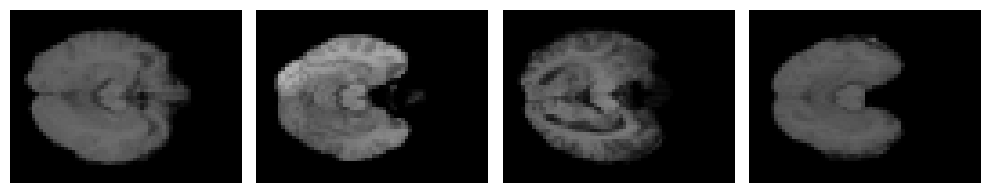

In [158]:
plt.subplots(1, 4, figsize=(10, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(train_ds[i * 20]["image"][0, :, :, 15].detach().cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [159]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [160]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [161]:
device

device(type='cuda', index=0)

In [162]:
import torch
print(torch.__version__)


2.1.0+cu121


In [163]:
import torchvision
print(torchvision.__version__)


0.16.0+cu121


#### Define Network 

In [191]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
model = VQVAE(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=(256, 256),
    num_res_channels=256,
    num_res_layers=2,
    downsample_parameters=((2, 4, 1, 1), (2, 4, 1, 1)),
    upsample_parameters=((2, 4, 1, 1, 0), (2, 4, 1, 1, 0)),
    num_embeddings=384,
    embedding_dim=48,
    ## try changing codebook dim 
)
model.to(device)

Using cuda


VQVAE(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): Convolution(
        (conv): Conv3d(1, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
        (adn): ADN(
          (A): ReLU()
        )
      )
      (1-2): 2 x VQVAEResidualUnit(
        (conv1): Convolution(
          (conv): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
        (conv2): Convolution(
          (conv): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
      )
      (3): Convolution(
        (conv): Conv3d(256, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
        (adn): ADN(
          (D): Dropout(p=0.0, inplace=False)
          (A): ReLU()
        )
      )
      (4-5): 2 x VQVAEResidualUnit(
        (conv1): Convolution(
          (conv): Conv3d(256, 256, kernel_size=(3, 3, 3), strid

In [205]:
import torch
# Assuming your VQVAE model is instantiated as `model`
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in model: {total_params}")

Total parameters in model: 37420081


In [209]:
encoder_params = sum(p.numel() for p in model.encoder.parameters())
decoder_params = sum(p.numel() for p in model.decoder.parameters())
codebook_params = sum(p.numel() for p in model.quantizer.parameters())

print(f"Encoder parameters: {encoder_params}")
print(f"Decoder parameters: {decoder_params}")
print(f"Codebook parameters: {codebook_params}")

Encoder parameters: 18700848
Decoder parameters: 18700801
Codebook parameters: 18432


In [208]:
for name, param in model.named_parameters():
    print(name)

encoder.blocks.0.conv.weight
encoder.blocks.0.conv.bias
encoder.blocks.1.conv1.conv.weight
encoder.blocks.1.conv1.conv.bias
encoder.blocks.1.conv2.conv.weight
encoder.blocks.1.conv2.conv.bias
encoder.blocks.2.conv1.conv.weight
encoder.blocks.2.conv1.conv.bias
encoder.blocks.2.conv2.conv.weight
encoder.blocks.2.conv2.conv.bias
encoder.blocks.3.conv.weight
encoder.blocks.3.conv.bias
encoder.blocks.4.conv1.conv.weight
encoder.blocks.4.conv1.conv.bias
encoder.blocks.4.conv2.conv.weight
encoder.blocks.4.conv2.conv.bias
encoder.blocks.5.conv1.conv.weight
encoder.blocks.5.conv1.conv.bias
encoder.blocks.5.conv2.conv.weight
encoder.blocks.5.conv2.conv.bias
encoder.blocks.6.conv.weight
encoder.blocks.6.conv.bias
decoder.blocks.0.conv.weight
decoder.blocks.0.conv.bias
decoder.blocks.1.conv1.conv.weight
decoder.blocks.1.conv1.conv.bias
decoder.blocks.1.conv2.conv.weight
decoder.blocks.1.conv2.conv.bias
decoder.blocks.2.conv1.conv.weight
decoder.blocks.2.conv1.conv.bias
decoder.blocks.2.conv2.conv.

### Shapes of the VQVAE

In [263]:
dummy_input = batch["image"][0]

In [265]:
dummy_input.shape

torch.Size([1, 48, 64, 48])

In [274]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
dummy_input = dummy_input.to(device)
encoder_output = model.encoder(dummy_input)

In [280]:
encoder_output.shape

torch.Size([48, 12, 16, 12])

## Model training

In [192]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
## diff lr
l1_loss = L1Loss()

#### Model Training 

In [ ]:
import os
import torchvision.transforms as transforms
from PIL import Image

n_epochs = 100
val_interval = 10
epoch_recon_loss_list = []
epoch_quant_loss_list = []
val_recon_epoch_loss_list = []
n_example_images = 4
intermediary_images = []
original_images_list = []
reconstructed_images_list = []
save_dir = "./reconstructed_images"  # Directory to save reconstructed images
os.makedirs(save_dir, exist_ok=True)

total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        # model outputs reconstruction and the quantization error
        reconstruction, quantization_loss = model(images=images)

        recons_loss = l1_loss(reconstruction.float(), images.float())

        loss = recons_loss + quantization_loss

        loss.backward()
        optimizer.step()

        epoch_loss += recons_loss.item()

        progress_bar.set_postfix(
            {"recons_loss": epoch_loss / (step + 1), "quantization_loss": quantization_loss.item() / (step + 1)}
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_quant_loss_list.append(quantization_loss.item() / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                reconstruction, quantization_loss = model(images=images)
                
                # previously, saving nexample_images
                # intermediary_images.append(reconstruction[:n_example_images, 0])
                original_images_list.append(images.cpu())  # Save original images (moved back to CPU for saving)
                reconstructed_images_list.append(reconstruction.cpu())

                recons_loss = l1_loss(reconstruction.float(), images.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_epoch_loss_list.append(val_loss)

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 92:  52%|███████▊       | 13/25 [01:58<01:40,  8.40s/it, recons_loss=0.00681, quantization_loss=1.13e-5]

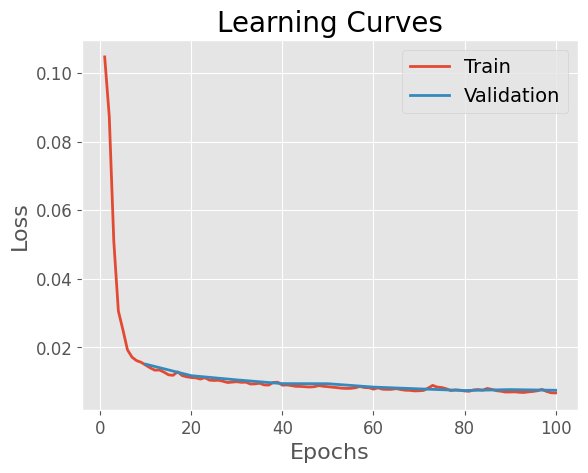

In [247]:
plt.style.use("ggplot")
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_recon_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
    val_recon_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

In [260]:
codebook_output = codebook(encoder_output)
print(f"Type of codebook output: {type(codebook_output)}")

# If it's a tuple, check its length
if isinstance(codebook_output, tuple):
    print(f"Number of outputs from codebook: {len(codebook_output)}")
    for i, output in enumerate(codebook_output):
        print(f"Output {i} shape: {output.shape}")

# Assign values dynamically based on the number of outputs
if len(codebook_output) == 2:
    quantized, encoding_indices = codebook_output
elif len(codebook_output) == 3:
    quantized, encoding_indices, extra = codebook_output
else:
    raise ValueError(f"Unexpected output format from codebook: {codebook_output}")

Type of codebook output: <class 'tuple'>
Number of outputs from codebook: 2
Output 0 shape: torch.Size([])
Output 1 shape: torch.Size([16, 48, 12, 16, 12])


In [252]:
device = next(model.parameters()).device  # Get model's device
input_image = batch["image"][0].to(device)  # Move input to same device as model

encoder_output = model.encoder(input_image)
print("Encoder Output Shape:", encoder_output.shape)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 5

In [255]:
device = next(model.parameters()).device  # Get model's device

input_image = batch["image"][0].to(device)  # Move input to model's device
encoder_output = model.encoder(input_image)  # Get encoder output

encoder_output = encoder_output.to(device)  # Ensure encoder output is on the same device

quantized, encoding_indices, _ = model.quantizer(encoder_output)

print("Quantized Output Shape (Codebook Output):", quantized.shape)
print("Encoding Indices Shape:", encoding_indices.shape)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 5

In [170]:
len(original_images_list)

60

In [171]:
len(reconstructed_images_list)

60

In [90]:
intermediary_images

[metatensor([[[[ 7.0292e-03,  2.1965e-03,  3.3904e-04,  ..., -2.7381e-05,
             3.6562e-03,  1.5137e-02],
           [ 2.3170e-03,  7.0232e-03,  6.3937e-04,  ...,  9.1986e-03,
            -2.4130e-04,  5.4887e-03],
           [ 1.4296e-03, -1.4563e-03,  1.1030e-04,  ..., -2.4477e-03,
            -8.9389e-04,  3.1605e-03],
           ...,
           [ 9.1926e-04,  4.8585e-03, -4.1774e-03,  ...,  1.8906e-03,
            -3.2270e-03,  5.4093e-03],
           [ 1.5711e-03, -7.0372e-04,  8.7725e-04,  ...,  9.2299e-04,
            -2.4880e-04,  4.7671e-03],
           [ 1.0933e-02,  1.6691e-02,  1.4159e-02,  ...,  1.5680e-02,
             1.3978e-02,  1.5366e-02]],
 
          [[ 1.9407e-02,  2.6594e-03,  5.6302e-03,  ...,  1.6741e-03,
             5.9306e-03,  1.2214e-02],
           [-1.9898e-04,  2.1335e-04,  4.7252e-04,  ..., -1.1580e-04,
            -2.8250e-03,  3.2321e-03],
           [ 1.5286e-03, -8.1075e-04, -2.4240e-03,  ..., -1.7151e-03,
            -1.6357e-03,  3.4746e-0

Shape of image 1: (1, 48, 64, 48)


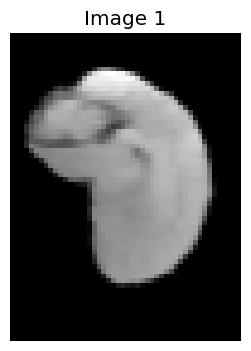

Shape of image 2: (1, 48, 64, 48)


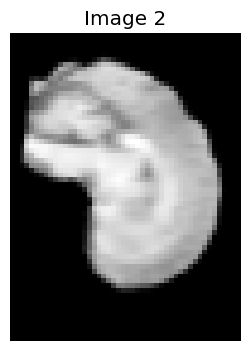

Shape of image 3: (1, 48, 64, 48)


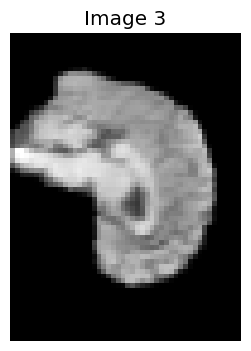

Shape of image 4: (1, 48, 64, 48)


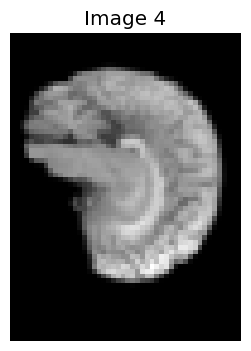

Shape of image 5: (1, 48, 64, 48)


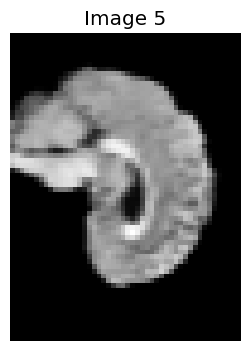

Shape of image 6: (1, 48, 64, 48)


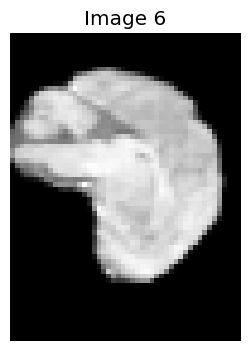

Shape of image 7: (1, 48, 64, 48)


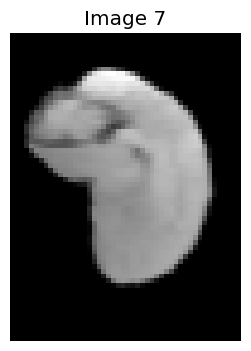

Shape of image 8: (1, 48, 64, 48)


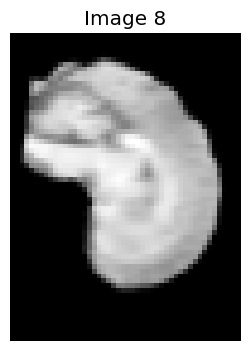

Shape of image 9: (1, 48, 64, 48)


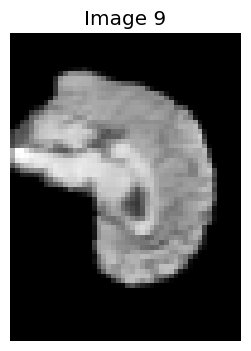

Shape of image 10: (1, 48, 64, 48)


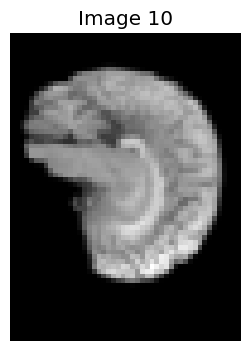

Shape of image 11: (1, 48, 64, 48)


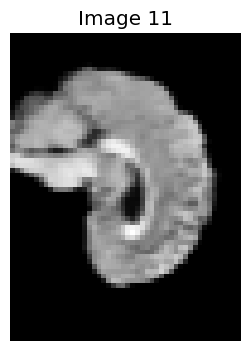

In [188]:
import matplotlib.pyplot as plt

# Loop through the first 3 images
for i in range(11):
    # Move tensor to CPU and convert it to a NumPy array
    img = original_images_list[i][0].cpu().numpy()
    
    # Check the shape of the tensor
    print(f"Shape of image {i + 1}: {img.shape}")
    
    # Select the first batch (image) and a slice from the depth (32) axis
    img_slice =img[0, 24, :, :]  # Selecting the 16th slice along the z-axis (depth)
    
    img_slice = img_slice.astype(np.float32)

    # Display the image
    plt.figure(figsize=(4, 4))
    plt.imshow(img_slice, cmap="gray")  # Assuming grayscale
    plt.title(f"Image {i + 1}")
    plt.axis("off")  # Turn off axes for better visibility
    plt.show()

In [180]:
print("Reconstructed Images Count ",len(intermediary_images))
print("Actual True Image Count validation", len(images))


Reconstructed Images Count  0
Actual True Image Count validation 16


In [186]:
reconstructed_images_list[0][0]

metatensor([[[[ 2.3368e-02,  1.5536e-02,  1.6009e-02,  ...,  1.7778e-02,
            1.7453e-02,  3.1045e-02],
          [ 2.0617e-02,  4.1791e-02,  2.6753e-02,  ...,  4.2638e-02,
            2.4001e-02,  3.1562e-02],
          [ 1.9465e-02, -2.0996e-03,  1.1711e-02,  ...,  2.6907e-03,
            1.2147e-02,  2.2455e-02],
          ...,
          [ 2.3983e-02,  4.1280e-02,  3.0812e-02,  ...,  4.1414e-02,
            2.9026e-02,  3.0861e-02],
          [ 1.9034e-02, -7.7388e-04,  1.0155e-02,  ...,  3.7753e-03,
            1.0949e-02,  2.3538e-02],
          [ 4.5568e-02,  4.4865e-02,  5.4015e-02,  ...,  4.4627e-02,
            5.3924e-02,  3.9601e-02]],

         [[ 3.6139e-02,  5.8280e-03,  2.2819e-02,  ...,  5.3996e-03,
            2.3612e-02,  1.3168e-02],
          [ 2.6462e-03, -1.7818e-04,  2.8374e-03,  ..., -2.0111e-03,
            6.0054e-03,  1.9292e-02],
          [ 3.7001e-02,  3.9228e-04,  9.5071e-04,  ..., -1.5585e-04,
            1.7015e-03, -1.8876e-04],
          ...,
 

Shape of image 1: (1, 48, 64, 48)


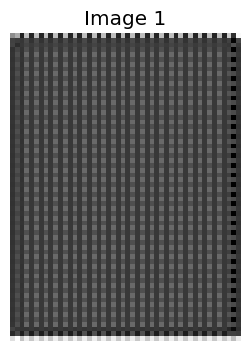

Shape of image 2: (1, 48, 64, 48)


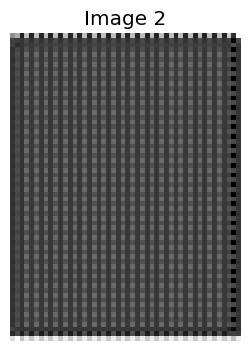

Shape of image 3: (1, 48, 64, 48)


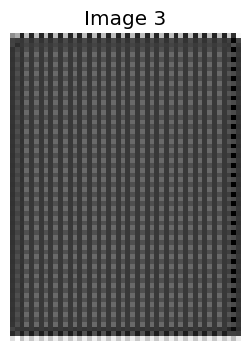

Shape of image 4: (1, 48, 64, 48)


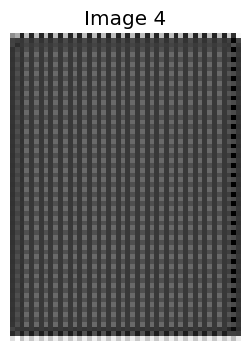

Shape of image 5: (1, 48, 64, 48)


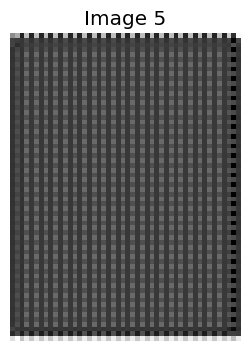

Shape of image 6: (1, 48, 64, 48)


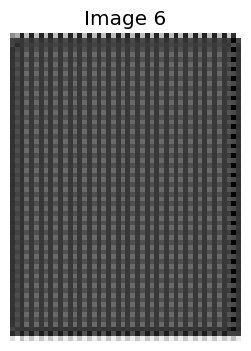

Shape of image 7: (1, 48, 64, 48)


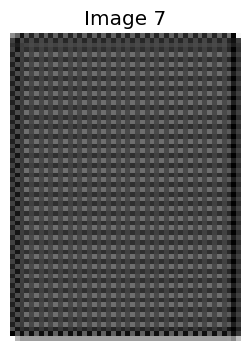

Shape of image 8: (1, 48, 64, 48)


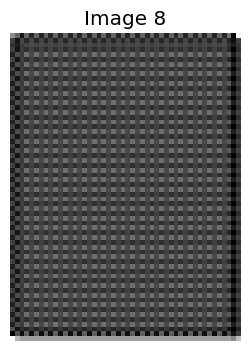

Shape of image 9: (1, 48, 64, 48)


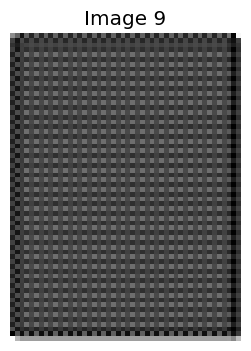

Shape of image 10: (1, 48, 64, 48)


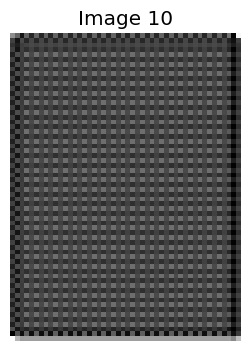

Shape of image 11: (1, 48, 64, 48)


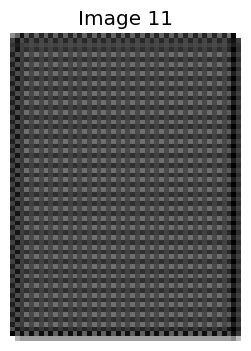

In [190]:
import matplotlib.pyplot as plt

# Loop through the first 3 images
for i in range(11):
    # Move tensor to CPU and convert it to a NumPy array
    img = reconstructed_images_list[i][0].cpu().numpy()
    
    # Check the shape of the tensor
    print(f"Shape of image {i + 1}: {img.shape}")
    
    # Select the first batch (image) and a slice from the depth (32) axis
    img_slice = img[0, 24, :, :]  # Selecting the 16th slice along the z-axis (depth)
    
    #img_slice = img_slice.astype(np.float32)
    

    # Display the image
    plt.figure(figsize=(4, 4))
    plt.imshow(img_slice, cmap="gray")  # Assuming grayscale
    plt.title(f"Image {i + 1}")
    plt.axis("off")  # Turn off axes for better visibility
    plt.show()

In [184]:
val_recon_epoch_loss_list

[0.0922957273821036,
 0.09119366357723872,
 0.09064724420507748,
 0.09052703529596329,
 0.09050454820195834,
 0.09064709146817525,
 0.09032788996895154,
 0.09029457345604897,
 0.09045510366559029,
 0.09031937271356583]

torch.Size([4, 32, 48, 32])
torch.Size([4, 32, 48, 32])
torch.Size([4, 32, 48, 32])
torch.Size([4, 32, 48, 32])
torch.Size([4, 32, 48, 32])
torch.Size([4, 32, 48, 32])
torch.Size([4, 32, 48, 32])
torch.Size([4, 32, 48, 32])
torch.Size([4, 32, 48, 32])
torch.Size([4, 32, 48, 32])


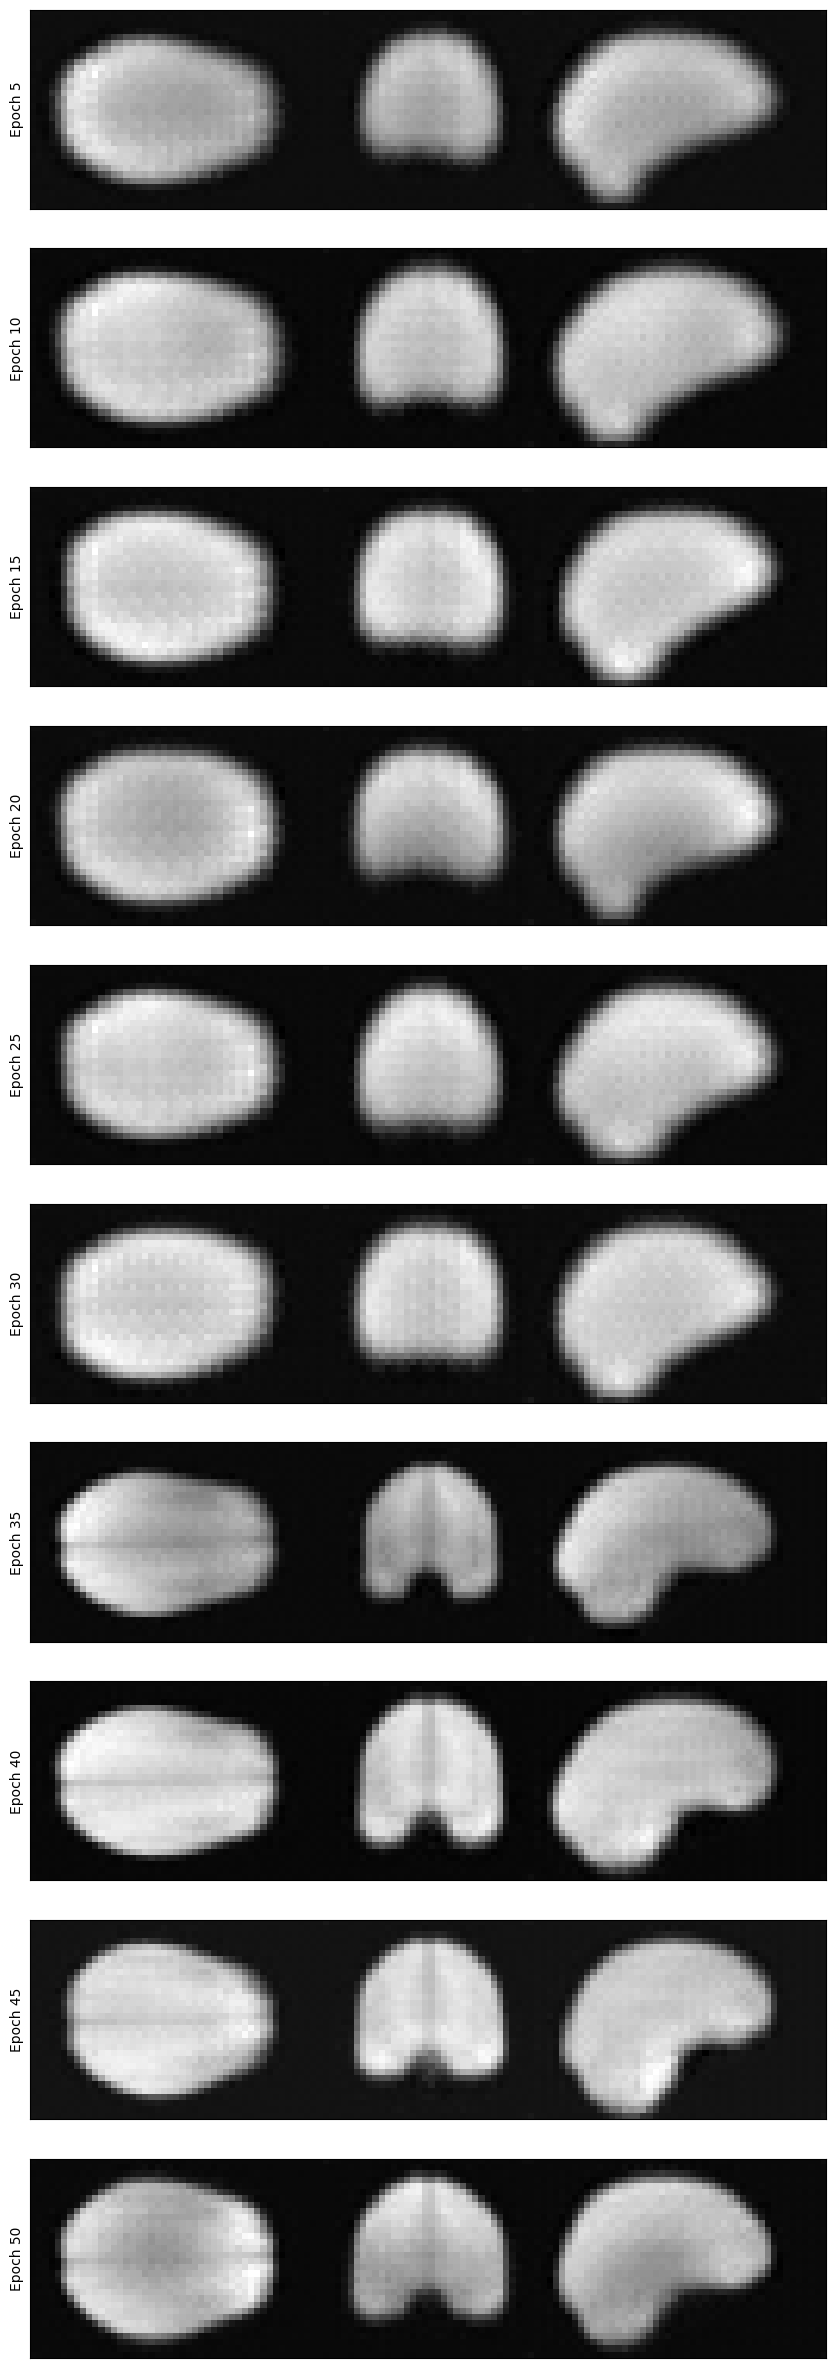

In [99]:
# Plot every evaluation as a new line and example as columns
val_samples = np.linspace(val_interval, n_epochs, int(n_epochs / val_interval))
fig, ax = plt.subplots(nrows=len(val_samples), ncols=1, sharey=True)
fig.set_size_inches(18.5, 30.5)
for image_n in range(len(val_samples)):
    reconstructions = intermediary_images[image_n]
    print(reconstructions.shape)
    reconstructions = np.concatenate(
        [
            reconstructions[0, :, :, 15],
            np.flipud(reconstructions[0, :, 24, :].T),
            np.flipud(reconstructions[0, 15, :, :].T),
        ],
        axis=1,
    )

    ax[image_n].imshow(reconstructions, cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

#### Plotting reconstructions 

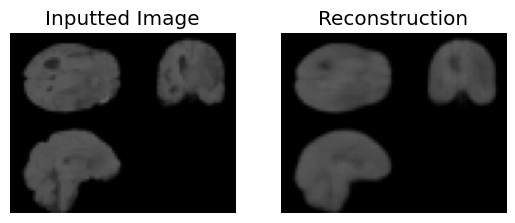

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=2)
plt.style.use("default")
plotting_image_0 = np.concatenate([images[0, 0, :, :, 15].cpu(), np.flipud(images[0, 0, :, 24, :].cpu().T)], axis=1)
plotting_image_1 = np.concatenate([np.flipud(images[0, 0, 15, :, :].cpu().T), np.zeros((32, 32))], axis=1)
image = np.concatenate([plotting_image_0, plotting_image_1], axis=0)

ax[0].imshow(image, vmin=0, vmax=1, cmap="gray")
ax[0].axis("off")
ax[0].title.set_text("Inputted Image")

plotting_image_2 = np.concatenate(
    [reconstruction[0, 0, :, :, 15].cpu(), np.flipud(reconstruction[0, 0, :, 24, :].cpu().T)], axis=1
)
plotting_image_3 = np.concatenate([np.flipud(reconstruction[0, 0, 15, :, :].cpu().T), np.zeros((32, 32))], axis=1)
reconstruction_3d = np.concatenate([plotting_image_2, plotting_image_3], axis=0)
ax[1].imshow(reconstruction_3d, vmin=0, vmax=1, cmap="gray")
ax[1].axis("off")
ax[1].title.set_text("Reconstruction")
plt.show()